In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
# PIL for visualization
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
%matplotlib inline

In [5]:
class TLClassifier(object):
    def __init__(self):
        #TODO load classifier
        SSD_GRAPH_FILE = 'frozen_inference_graph.pb'        
        #self.session = None
        self.detection_graph = self.__load_graph(SSD_GRAPH_FILE)
        
        # visualization
        cmap = ImageColor.colormap        
        self.COLOR_LIST = sorted([c for c in cmap.keys()])
    
    def __load_graph(self, graph_file):
        """Loads a frozen inference graph"""
        graph = tf.Graph()
        with graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(graph_file, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
        print("model loaded")
                
        return graph
    
    def get_classification(self, cv2_img):
        """Determines the color of the traffic light in the image

        Args:
            image (cv::Mat): image containing the traffic light

        Returns:
            int: ID of traffic light color (specified in styx_msgs/TrafficLight)

        """
        #TODO implement light color prediction
        
        #image = cv2.resize(image, (300, 300))
        cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(cv2_img)
        image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
        
        with tf.Session(graph = self.detection_graph) as sess:   
            # The input placeholder for the image. Get_tensor_by_name` returns the Tensor with the associated name in the Graph.
            image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
            # The classification of the object (integer id).
            detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')             
            # Actual detection.
            (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

            # Remove unnecessary dimensions
            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes)
            
            confidence_cutoff = 0.7    # was 0.8
            # Filter boxes with a confidence score less than `confidence_cutoff`
            boxes, scores, classes = self.__filter_boxes(confidence_cutoff, boxes, scores, classes)
            # The current box coordinates are normalized to a range between 0 and 1.
            # This converts the coordinates actual location on the image.
            width, height = image.size
            box_coords = self.__to_image_coords(boxes, height, width)            
            # Each class with be represented by a differently colored box
            # Draw Box for Tuning            
            self.__draw_boxes(image, box_coords, classes)            
            plt.imshow(image)
            plt.show()
            
            light_state = 4
            if len(classes)>0:
                light_state = self.__classifier(cv2_img, box_coords, classes)
                
        print("light_state",light_state)
        return light_state
    
    def __filter_boxes(self, min_score, boxes, scores, classes):
        """Return boxes with a confidence >= `min_score`"""
        n = len(classes)
        idxs = []
        for i in range(n):
            if scores[i] >= min_score:
                idxs.append(i)
    
        filtered_boxes = boxes[idxs, ...]
        filtered_scores = scores[idxs, ...]
        filtered_classes = classes[idxs, ...]
        return filtered_boxes, filtered_scores, filtered_classes

    def __to_image_coords(self, boxes, height, width):
        """
        The original box coordinate output is normalized, i.e [0, 1].
    
        This converts it back to the original coordinate based on the image
        size.
        """
        box_coords = np.zeros_like(boxes)
        box_coords[:, 0] = boxes[:, 0] * height
        box_coords[:, 1] = boxes[:, 1] * width
        box_coords[:, 2] = boxes[:, 2] * height
        box_coords[:, 3] = boxes[:, 3] * width
    
        return box_coords

    def __draw_boxes(self, image, boxes, classes, thickness=4):
        """Draw bounding boxes on the image"""
        draw = ImageDraw.Draw(image)
        for i in range(len(boxes)):
            bot, left, top, right = boxes[i, ...]
            class_id = int(classes[i])
            color = self.COLOR_LIST[class_id]
            draw.line([(left, top), (left, bot), (right, bot), 
                       (right, top), (left, top)], width=thickness, fill=color)
    
    def __classifier(self, image, boxes, classes):
        traffic_counter = 0
        predict_sum = 0.
        for i in range(len(boxes)):
            if (classes[i]==10):
                traffic_counter += 1
                bot, left, top, right = boxes[i, ...]
                crop_image = image[int(bot):int(top), int(left):int(right)]
                '''
                Traffic Light classifier - project from intro to self driving cars
                '''  
                predict_sum += self.__estimate_label(crop_image)    
        # traffic_counter ==0 means there is no object detect as traffic            
        if (traffic_counter !=0):
            avg = predict_sum/traffic_counter
            print("This groupb brightness value: ",avg)
        else:
            avg = 0        

        '''
        Traffic light definition in UNKNOWN=4
        GREEN=2  YELLOW=1  RED=0 
        '''
        if (avg > 3.0):
            return 0
        else:
            return 4
                     
    '''
    Traffic Light classifier - reuse project from intro-to-self-driving-cars
    '''
    def __estimate_label(self, rgb_image):  
        rgb_image = cv2.resize(rgb_image,(32,32))
        test_image_hsv = cv2.cvtColor(np.array(rgb_image), cv2.COLOR_RGB2HSV)
        # Mask HSV channel
        masked_red = self.__mask_red(test_image_hsv, rgb_image)   
        Masked_R_V = self.__Masked_Image_Brightness(masked_red)  
        AVG_Masked_R = self.__AVG_Brightness(Masked_R_V)    
        plt.imshow(masked_red)
        plt.show()
        plt.imshow(Masked_R_V, cmap='gray') 
        plt.show()
        print("brightness avg value: %d" %AVG_Masked_R)
        return AVG_Masked_R
    
    def __mask_red(self, HSV_image, rgb_image):    
        #red_mask_1 = cv2.inRange(HSV_image, (0,50,60), (10,255,255))
        red_mask = cv2.inRange(HSV_image, (140,10,100), (180,255,255)) #was (140,36,100)
        #red_mask = np.add(red_mask_1,red_mask_2)
        masked_image = np.copy(rgb_image)
        masked_image[red_mask == 0] = [0, 0, 0]
        return masked_image    
    
    def __Masked_Image_Brightness(self, image):
        masked_Image_HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        masked_Image_V = masked_Image_HSV[:,:,2]
        return masked_Image_V
    
    def __AVG_Brightness(self, image):
        height, width = image.shape
        brightness_avg = np.sum(image)/(height*width)
        return brightness_avg

In [6]:
detect = TLClassifier()

model loaded


In [7]:
image = cv2.imread("test_image/traffic_light_69.jpg")
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

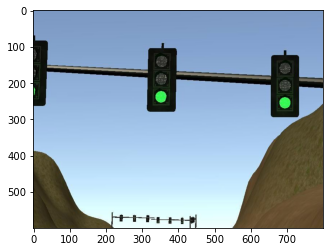

In [8]:
plt.imshow(image2)

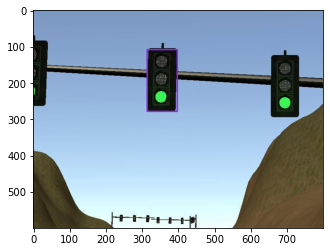

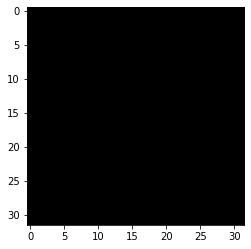

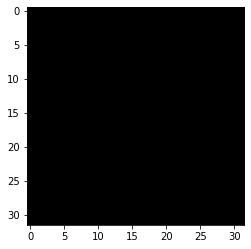

brightness avg value: 0
counter:  1
This groupb brightness value:  0.0
light_state 4


4

In [226]:
detect.get_classification(image)